# Shor's Algorithm

Shor's Algorithm significantly enhances the efficiency of integer factorization, making it exponentially faster than classical methods.

In this notebook, we demonstrate Shor's Algorithm factoring the integer 15.

1. [Introduction](#1.-Introduction)
2. [Controlled Modular Exponentiation](#2.-Controlled-Modular-Exponentiation-Operation)
3. [Quantum Fourier Transform](#3.-Quantum-Fourier-Transform)
4. [Circuit Construction](#4.-Circuit-Construction)
5. [Execution](#5.-Execution)
6. [Post Processing](#6.-Post-Processing)

## 1. Introduction

### Imports

In [ ]:
%pip install numpy
%pip install qiskit
%pip install qiskit_ibm_runtime
%pip install qiskit_aer

In [1]:
import numpy as np
import math
from qiskit import QuantumCircuit
from qiskit.circuit.library import CUGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager as gppm
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator

## 2. Controlled Modular Exponentiation Operation
As an example, say we want to factor $N = 15$.

## Shor's Algorithm


### Step 1. Choose a random integer $a$:
- Pick $a = 2$.
  
- Compute $\gcd(a, N)$ . Since  gcd(2, 15) = 1 , we continue.

### Step 2. Find the period $r$ of $a$ mod N:
- The order $r$ is the smallest integer such that: $2^r =\mod{15}$.
    
- Quantum period-finding determines $r$ = 4.

### Step 3. Check if $r$ is even:
- Since $r = 4$ is even, we proceed.

### Step 4. Compute potential factors of $N$:
- Compute: $a^{r/2}$ - 1 and $a^{r/2}$ + 1.

- Compute gcd with $N = 15$:
$$p = \gcd(3, 15) = 3, \quad q = \gcd(5, 15) = 5$$
  
- This successfully factors $15$ into $3 \cdot 5$.

### Circuit of Shor's Algorithm 

<img src="shor_images/Picture1.png">

In [2]:
def c_amod15(a,power):
    U = QuantumCircuit(4)
    for _ in range(power):
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" %(a,power)
    c_U = U.control()
    return c_U

## 3. Quantum Fourier Transform

Finding $r$ in polynomial time.

In [3]:
def qft(n):
    #Initialize quantum circuit
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            angle = -(np.pi/float(2**(j-m)))
            cu1_gate = CUGate(0,0,0,angle)
            qc.append(cu1_gate, [m, j])
        qc.h(j)
    qc.name = "QFT"
    return qc

## 4. Circuit Construction

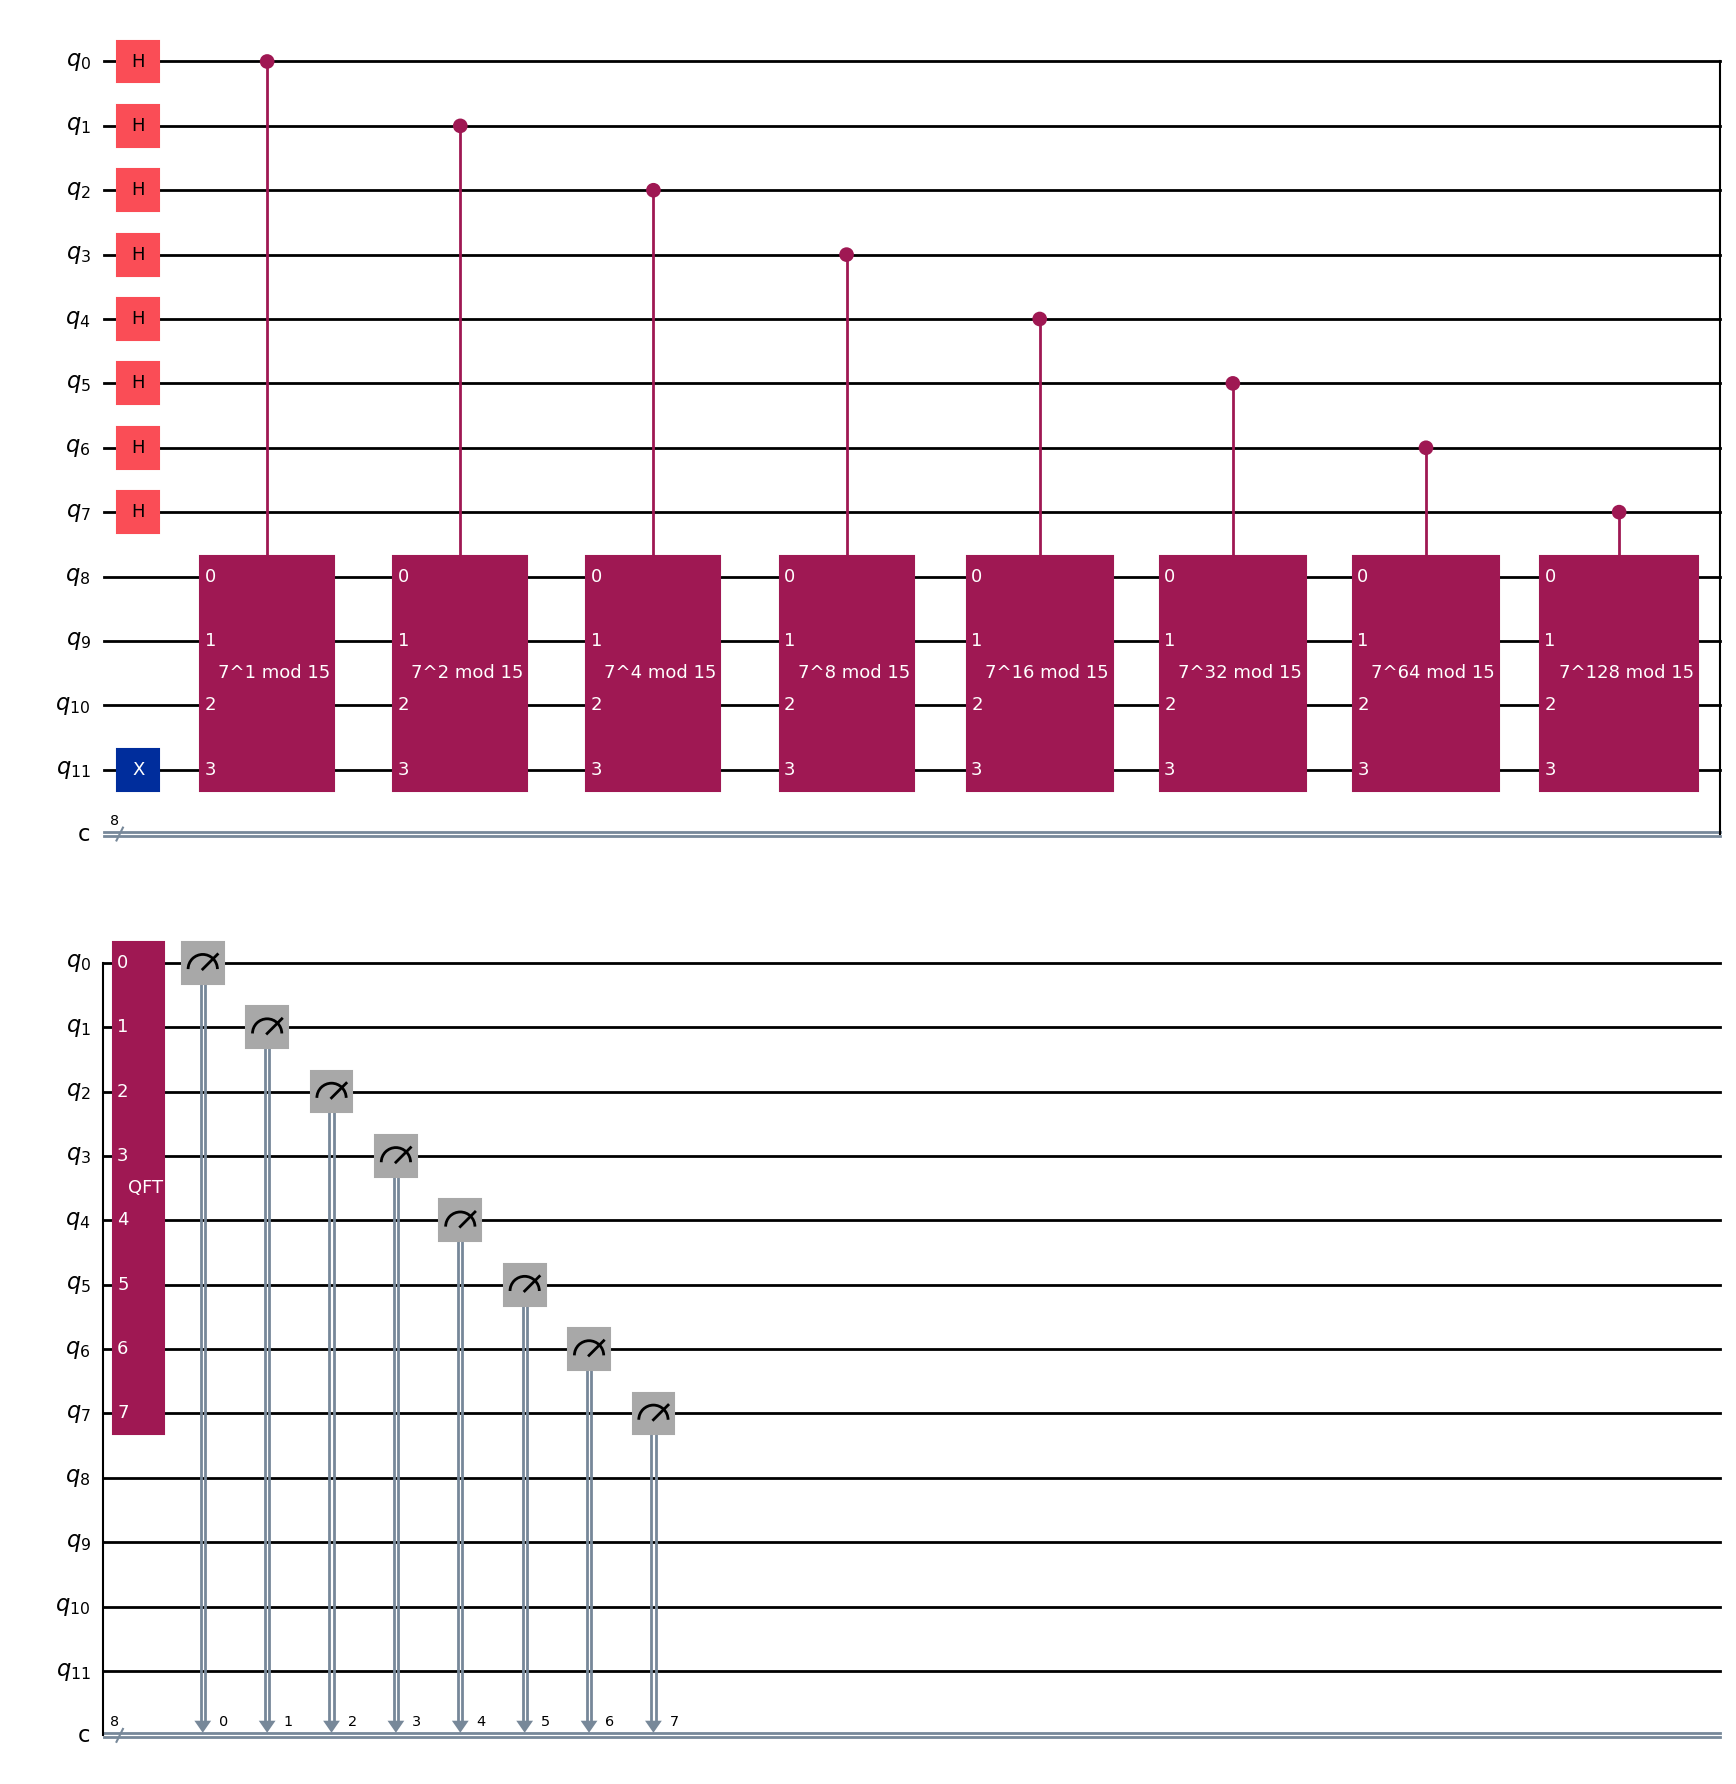

In [4]:
n_count = 8
a = 7

qc = QuantumCircuit(n_count + 4, n_count)

for q in range(n_count):
    qc.h(q)

qc.x(3+n_count)

for q in range(n_count):
    qc.append(c_amod15(a,2**q), [q]+[i+n_count for i in range(4)])

qc.append(qft(n_count), range(n_count))
qc.measure(range(n_count), range(n_count))
qc.draw('mpl')

## 5. Execution

In [5]:
service = QiskitRuntimeService()
backend = AerSimulator()
pm = gppm(backend=backend, optimization_level = 1)
isa_circuit = pm.run(qc)
sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots = 4096)

## 6. Post Processing

The factors of 15 are 3 and 5.


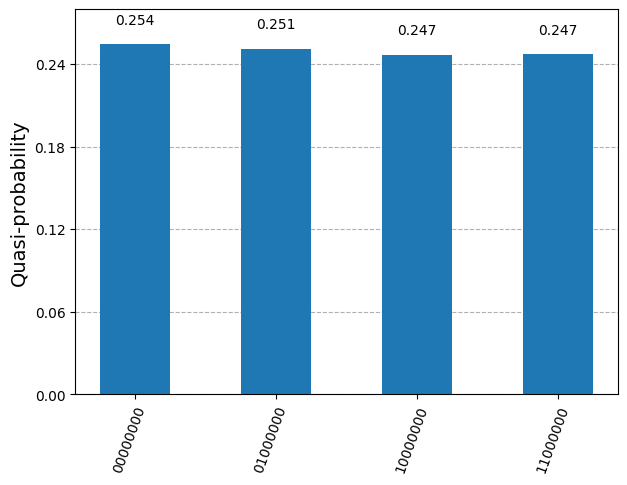

In [6]:
nums = job.result()[0].data.c.get_counts()
new = {
    '00000000':0,
    '01000000':0,
    '10000000':0,
    '11000000':0
}

denoms = set()
for key, value in nums.items():
    if(key[:2]=='00'):
        new['00000000'] += value
    elif(key[:2]=='01'):
        new['01000000'] += value
    elif(key[:2]=='10'):
        new['10000000'] += value
    elif(key[:2]=='11'):
        new['11000000'] += value

for key in new:
    gcd = math.gcd(int(key, 2), 2**n_count)
    denom = (2**n_count)//gcd
    if (denom%2==0 and (a**denom)%15 != 14):
        denoms.add((2**n_count)//gcd)
        
r = max(denoms)
p = (math.gcd(a**(r//2)-1, 15))
q = (math.gcd(a**(r//2)+1, 15))
print("The factors of 15 are " + str(p) + " and " + str(q) + ".")
plot_distribution(new)